In [1]:
import pandas as pd
import numpy as np
#import random
import copy
import matplotlib.pyplot as plt
#import xgboost as xgb
from sklearn.ensemble import IsolationForest
#from sklearn.neighbors import LocalOutlierFactor
#from sklearn.preprocessing import RobustScaler
#from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn import metrics
from catboost import CatBoostRegressor, Pool, cv

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Загрузим файл с признаками

In [3]:
features = pd.read_excel('C:\\Users\\dgalk\\shad_final_project\\features_rest_Russia.xlsx')

Полный список признаков

In [4]:
col_full = ['BrandCodes', 'BrickCode', 
           'Cash', 'Card', 'Internet', 'Bank',
           'population', 'VRP', 
           'NumHos','NumAmb', 'NumPhc',
           'APT', 'PCP', 'PHK', 'PHN', 'PST',
           'top_brand_0', 'top_brand_1', 'top_brand_11', 'top_brand_7', 'top_brand_14',
           'top_brand_31', 'top_brand_10', 'top_brand_84', 'top_brand_17', 'top_brand_2', 
           'top_sales_1', 'top_sales_0', 'top_sales_11', 'top_sales_31', 'top_sales_14',
           'top_sales_84', 'top_sales_41', 'top_sales_7', 'top_sales_9', 'top_sales_10',
           'top_sales_133', 'top_sales_17', 'top_sales_34', 'top_sales_32', 'top_sales_39',
           'Metro_dist', 'Metro_num',   
           'АО', 'Респ', 'край', 'обл', 
           'аллея', 'б-р', 'городок',
           'дор', 'заезд', 'кв-л', 'км', 'линия', 'мкр', 'наб', 'нп', 'п', 'парк',
           'пер', 'пл', 'пр-кт', 'проезд', 'просека', 'рзд', 'ряды', 'сл', 'спуск',
           'тер', 'тракт', 'туп', 'ул', 'уч-к', 'ш', 
           'Rate123', 'Rate1', 'Rate2', 'Rate3', 'Rate_mean',
           'weekdays_work_time',
           'weekend_work_time',  
           'is_work_time_almost_24_7',
           #'uniq_sku_mean_median3', 'sell_mean_median3', 'avg_sell_sku_median3',
           'uniq_sku_mean_summer_median3', 
           'uniq_sku_mean_autumn_median3',
           'uniq_sku_mean_winter_median3', 
           'uniq_sku_mean_spring_median3',
           'sell_mean_summer_median3', 
           'sell_mean_autumn_median3', 
           'sell_mean_winter_median3', 
           'sell_mean_spring_median3',
           'avg_sell_sku_summer_median3',
           'avg_sell_sku_autumn_median3',
           'avg_sell_sku_winter_median3',
           'avg_sell_sku_spring_median3',
           'num_pharm', 'region_popul', 'soul_on_pharm',
           'debcred', 'pens_proc', 'prod_basket', 'pharm_basket', 
]

In [5]:
# признаки
X = features[col_full]
# целевая переменная
y = features[['Basket1', 'Basket2', 'Basket3']]

## Посмотрим на 2-ую корзину

In [6]:
print("Кол-во объектов basket2: {0}".format(y["Basket2"].dropna().size))

Кол-во объектов basket2: 9947


Удалим из нее объекты, где Apharm = 1 и Nan

In [7]:
bask2 = y["Basket2"][features.Apharm == 0].dropna()
print("Итоговое кол-во объектов без Apharm=1: {0}".format(bask2.size))

Итоговое кол-во объектов без Apharm=1: 9217


Т.е. порядка 700 убрали из рассмотрения

Посмотрим на гистограмму распределения

In [8]:
def plot_hist(data, title=''):
    fig = plt.figure(figsize = (10,5))
    ax = fig.gca()
    data.plot.hist(grid=True, bins=20, ax=ax, rwidth=0.9, color='#607c8e')
    ax.set_title(title, fontsize=20)
    ax.set_ylabel('Частоты', fontsize=20)
    ax.set_xlabel('Объем корзины', fontsize=20)  

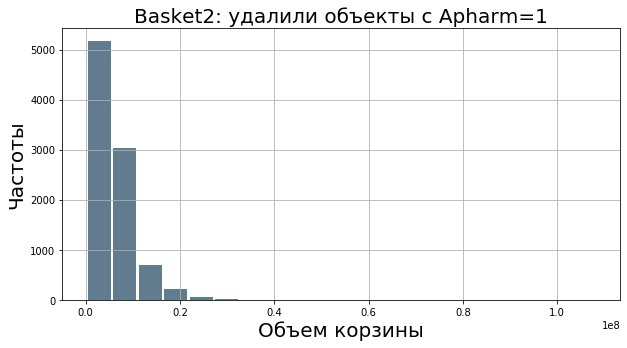

In [9]:
plot_hist(bask2, 'Basket2: удалили объекты с Apharm=1')

Построим график basket2 по возрастанию значений 

In [10]:
def plot_one_graphic_sorted(y, figsize=(10,5), linewidth=4, color='tab:brown', label=''):
    indices = np.argsort(y)
    x_plt = np.arange(0, y.size)
    y_plt = y.iloc[indices]
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(x_plt, y_plt, color=color, linewidth=linewidth, label=label)
    ax.grid(linestyle='--')
    ax.legend()

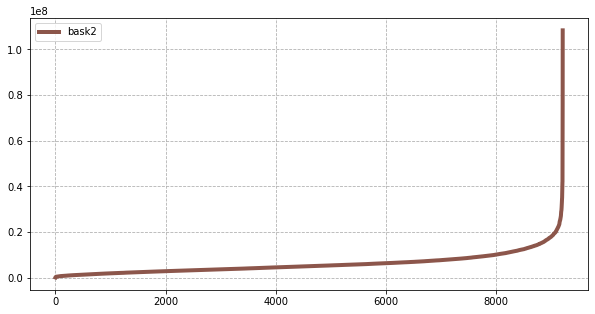

In [11]:
plot_one_graphic_sorted(bask2, label='bask2')

Собственно, видим то, что и на гистаграмме: ярко выраженный хвост с большими значениями. 

# Деление на трейн и отложенный тест

In [12]:
def get_XY(X_, y_, random_state=123):
    
    y = y_[features.Apharm == 0].dropna()
    X = X_.loc[y.index, :]
    
    X_train, X_test, y_train, y_test = \
                train_test_split(X, y, 
                                 test_size=0.2,
                                 random_state=random_state,
                                 shuffle=True)
    
    return X_train, X_test, y_train, y_test

In [13]:
X_train, X_test, y_train, y_test = get_XY(X, y, random_state=123)

# Отсеивание аномалий в целевой переменной на трейне с помощью IsolationForest

*В конечном итоге отказались от поиска и выкидывания аномалий, т.к. это приводило к ухудшению качества. Модель обучалась на "чистых" данных, а тест содержит аномалии, что априори приведет к тому, что модель их не предскажет. Поэтому решили обучать модель и на аномалиях.*

*Кусок, связанный с поиском аномалий и оптимальных параметров, отсюда вырезан, чтобы не усложнять чтение блокнота*

# Basket2

## Basket2: *первый baseline*

In [16]:
def cv_res(X, y, median, iterations=None, depth=None, lr=None, l2=None):
    
    cv_dataset = Pool(data=X, label=y)

    params = {"iterations": iterations,
              "depth": depth,
              "learning_rate": lr,
              "l2_leaf_reg": l2,
              "loss_function": "RMSE",
              "custom_metric": ['R2', 'RMSE', 'MAE', 'MAPE'],
              "verbose": False}

    scores = cv(cv_dataset,
                params,
                fold_count=5)
    
    index_min_rmse = np.argmin(scores['test-RMSE-mean'])

    print("====================")
    print("  cross-validation")
    print("====================")

    rmse_mean = scores['test-RMSE-mean'][index_min_rmse]
    rmse_std = scores['test-RMSE-std'][index_min_rmse]
    print("RMSE:\t{0} +- {1}".format(np.round(rmse_mean), np.round(2 * rmse_std)))

    mae_mean = scores['test-MAE-mean'][index_min_rmse]
    mae_std = scores['test-MAE-std'][index_min_rmse]
    print("MAE:\t{0} +- {1}\t({2} %)".format(np.round(mae_mean), np.round(2 * mae_std),
         np.round(mae_mean / median * 100)))

    r2_mean = scores['test-R2-mean'][index_min_rmse]
    r2_std = scores['test-R2-std'][index_min_rmse]
    print("R2:\t{0} +- {1}".format(np.round(r2_mean, 3), np.round(2 * r2_std, 3)))

    mape_mean = scores['test-MAPE-mean'][index_min_rmse]
    mape_std = scores['test-MAPE-std'][index_min_rmse]
    print("MAPE:\t{0} +- {1}".format(np.round(mape_mean, 3), np.round(2 * mape_std, 3)))
    
    return index_min_rmse

In [31]:
def test_res(X_train, y_train, X_test, y_test,
             iterations=None, depth=None, lr=None, l2=None):
    
    eval_dataset = Pool(X_test, y_test)
    
    model = CatBoostRegressor(iterations=iterations,
                              depth=depth,
                              learning_rate=lr,
                              l2_leaf_reg=l2,
                              custom_metric=['R2', 'RMSE', 'MAE', 'MAPE'])
    
    model.fit(X_train, y_train, eval_set=eval_dataset, verbose=False)
    
    print("====================")
    print("    train - test")
    print("====================")
    
    print("RMSE:\t", end='')
    print("train: {0}\ttest: {1}".format(np.round(model.evals_result_['learn']['RMSE'][-1]), 
                                         np.round(model.evals_result_['validation']['RMSE'][-1])))
    
    print("R2:\t", end='')
    print("train: {0}\t\ttest: {1}".format(np.round(model.evals_result_['learn']['R2'][-1], 3), 
                                         np.round(model.evals_result_['validation']['R2'][-1], 3)))
    
    print("MAE:\t", end='')
    print("train: {0}\ttest: {1}".format(np.round(model.evals_result_['learn']['MAE'][-1]), 
                                         np.round(model.evals_result_['validation']['MAE'][-1])))
    
    print("MAPE:\t", end='')
    print("train: {0}\t\ttest: {1}".format(np.round(model.evals_result_['learn']['MAPE'][-1], 3), 
                                         np.round(model.evals_result_['validation']['MAPE'][-1], 3)))

Кросс-валидация

In [28]:
best_iter_ = cv_res(X_train, y_train['Basket2'], y_train['Basket2'].median())

  cross-validation
RMSE:	2519719.0 +- 457323.0
MAE:	1421436.0 +- 59844.0	(28.0 %)
R2:	0.688 +- 0.074
MAPE:	0.348 +- 0.025


In [29]:
model = CatBoostRegressor(custom_metric=['R2', 'RMSE', 'MAE', 'MAPE'])

grid = {'learning_rate': [0.03, 0.05, 0.07, 0.1],
        'depth': [4, 5, 6, 7, ],
        'l2_leaf_reg': [1, 2, 3, 4]}

grid_search_result = model.grid_search(grid, 
                                       X=X_train, 
                                       y=y_train['Basket2'],
                                       cv=5,
                                       verbose=False,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 2836047.622
bestIteration = 999


bestTest = 2837525.552
bestIteration = 981


bestTest = 2801744.917
bestIteration = 999


bestTest = 2759396.961
bestIteration = 933


bestTest = 2864667.216
bestIteration = 999


bestTest = 2768056.2
bestIteration = 998


bestTest = 2786545.581
bestIteration = 980


bestTest = 2790804.005
bestIteration = 980


bestTest = 2875963.861
bestIteration = 999


bestTest = 2791895.335
bestIteration = 999


bestTest = 2775502.973
bestIteration = 999


bestTest = 2764600.31
bestIteration = 998


bestTest = 2888920.785
bestIteration = 997


bestTest = 2834455.314
bestIteration = 911


bestTest = 2767012.778
bestIteration = 985


bestTest = 2792521.9
bestIteration = 997


bestTest = 2804338.276
bestIteration = 998


bestTest = 2755126.726
bestIteration = 999


bestTest = 2728292.367
bestIteration = 999


bestTest = 2813860.084
bestIteration = 972


bestTest = 2809751.614
bestIteration = 999


bestTest = 2733676.2
bestIteration = 985


bestTest = 27727

   Возьмем параметры, при которых на трейне худший результат, тогда переобучение меньше
    
<li>depth = 4
    
<li>learning_rate = 0.03
    
<li>l2_leaf_reg = 4

In [32]:
test_res(X_train=X_train, y_train=y_train['Basket2'],
         X_test=X_test, y_test=y_test['Basket2'],
         iterations=1000, depth=4, lr=0.03, l2=4)

    train - test
RMSE:	train: 2001016.0	test: 3023326.0
R2:	train: 0.804		test: 0.605
MAE:	train: 1311023.0	test: 1462682.0
MAPE:	train: 0.331		test: 0.331


## Basket2: *уменьшение кол-ва признаков*

In [130]:
num_features = [90, 80, 70, 60, 50, 40, 30, 25]

model = CatBoostRegressor(iterations=1000,
                          depth=4,
                          learning_rate=0.03,
                          l2_leaf_reg=4,
                          verbose=0)

col_ = col_full

for nf in num_features:
    X_ = X_train[col_]
    y_ = y_train['Basket2']
    selector = RFE(model, n_features_to_select=nf, step=1, verbose=0)
    selector = selector.fit(X_, y_)

    col_new = [col_[i] for i, b in enumerate(selector.support_) if b]
    print('***{0} признаков***'.format(nf))
    print(col_new)
    col_ = copy.copy(col_new)

***90 признаков***
['BrandCodes', 'BrickCode', 'Cash', 'Card', 'Internet', 'Bank', 'population', 'VRP', 'NumHos', 'NumAmb', 'NumPhc', 'APT', 'PCP', 'PHK', 'PHN', 'top_brand_0', 'top_brand_1', 'top_brand_11', 'top_brand_7', 'top_brand_14', 'top_brand_31', 'top_brand_10', 'top_brand_84', 'top_brand_17', 'top_brand_2', 'top_sales_1', 'top_sales_0', 'top_sales_11', 'top_sales_31', 'top_sales_14', 'top_sales_84', 'top_sales_7', 'top_sales_9', 'top_sales_10', 'top_sales_133', 'top_sales_17', 'top_sales_34', 'top_sales_32', 'top_sales_39', 'Metro_dist', 'Metro_num', 'АО', 'Респ', 'край', 'обл', 'б-р', 'кв-л', 'линия', 'мкр', 'наб', 'нп', 'п', 'парк', 'пер', 'пл', 'пр-кт', 'проезд', 'просека', 'рзд', 'спуск', 'тракт', 'ул', 'ш', 'Rate123', 'Rate1', 'Rate2', 'Rate3', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'is_work_time_almost_24_7', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_m

Ну и чтобы не перезапускать в след. раз

In [14]:
col_90_features = \
['BrandCodes', 'BrickCode', 'Cash', 'Card', 'Internet', 'Bank', 'population', 'VRP', 'NumHos', 'NumAmb', 'NumPhc', 'APT', 'PCP', 'PHK', 'PHN', 'top_brand_0', 'top_brand_1', 'top_brand_11', 'top_brand_7', 'top_brand_14', 'top_brand_31', 'top_brand_10', 'top_brand_84', 'top_brand_17', 'top_brand_2', 'top_sales_1', 'top_sales_0', 'top_sales_11', 'top_sales_31', 'top_sales_14', 'top_sales_84', 'top_sales_7', 'top_sales_9', 'top_sales_10', 'top_sales_133', 'top_sales_17', 'top_sales_34', 'top_sales_32', 'top_sales_39', 'Metro_dist', 'Metro_num', 'АО', 'Респ', 'край', 'обл', 'б-р', 'кв-л', 'линия', 'мкр', 'наб', 'нп', 'п', 'парк', 'пер', 'пл', 'пр-кт', 'проезд', 'просека', 'рзд', 'спуск', 'тракт', 'ул', 'ш', 'Rate123', 'Rate1', 'Rate2', 'Rate3', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'is_work_time_almost_24_7', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_median3', 'sell_mean_autumn_median3', 'sell_mean_winter_median3', 'sell_mean_spring_median3', 'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 'num_pharm', 'region_popul', 'soul_on_pharm', 'debcred', 'pens_proc', 'prod_basket', 'pharm_basket']
col_80_features = \
['BrandCodes', 'BrickCode', 'Cash', 'Card', 'Internet', 'Bank', 'population', 'VRP', 'NumHos', 'NumAmb', 'NumPhc', 'APT', 'PCP', 'top_brand_0', 'top_brand_1', 'top_brand_11', 'top_brand_7', 'top_brand_14', 'top_brand_31', 'top_brand_10', 'top_brand_84', 'top_brand_17', 'top_brand_2', 'top_sales_1', 'top_sales_0', 'top_sales_11', 'top_sales_31', 'top_sales_14', 'top_sales_84', 'top_sales_7', 'top_sales_9', 'top_sales_10', 'top_sales_133', 'top_sales_17', 'top_sales_34', 'top_sales_32', 'top_sales_39', 'Metro_dist', 'Metro_num', 'край', 'обл', 'б-р', 'кв-л', 'линия', 'мкр', 'наб', 'нп', 'п', 'парк', 'пер', 'пл', 'пр-кт', 'спуск', 'Rate123', 'Rate1', 'Rate2', 'Rate3', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'is_work_time_almost_24_7', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_median3', 'sell_mean_autumn_median3', 'sell_mean_winter_median3', 'sell_mean_spring_median3', 'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 'num_pharm', 'region_popul', 'soul_on_pharm', 'debcred', 'pens_proc', 'prod_basket', 'pharm_basket']
col_70_features = \
['BrandCodes', 'BrickCode', 'Cash', 'Card', 'Internet', 'Bank', 'population', 'VRP', 'NumHos', 'NumAmb', 'NumPhc', 'APT', 'PCP', 'top_brand_0', 'top_brand_1', 'top_brand_11', 'top_brand_7', 'top_brand_14', 'top_brand_31', 'top_brand_10', 'top_brand_84', 'top_brand_17', 'top_brand_2', 'top_sales_1', 'top_sales_0', 'top_sales_11', 'top_sales_31', 'top_sales_14', 'top_sales_84', 'top_sales_7', 'top_sales_9', 'top_sales_10', 'top_sales_133', 'top_sales_17', 'top_sales_34', 'Metro_dist', 'край', 'обл', 'б-р', 'кв-л', 'линия', 'мкр', 'наб', 'Rate123', 'Rate1', 'Rate2', 'Rate3', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'is_work_time_almost_24_7', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_median3', 'sell_mean_autumn_median3', 'sell_mean_winter_median3', 'sell_mean_spring_median3', 'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 'num_pharm', 'region_popul', 'soul_on_pharm', 'debcred', 'pens_proc', 'prod_basket', 'pharm_basket']
col_60_features = \
['BrandCodes', 'BrickCode', 'Cash', 'Card', 'Bank', 'population', 'VRP', 'NumHos', 'NumAmb', 'NumPhc', 'APT', 'PCP', 'top_brand_0', 'top_brand_1', 'top_brand_11', 'top_brand_7', 'top_brand_14', 'top_brand_31', 'top_brand_10', 'top_brand_84', 'top_brand_17', 'top_sales_1', 'top_sales_0', 'top_sales_11', 'top_sales_31', 'top_sales_14', 'top_sales_84', 'top_sales_7', 'top_sales_9', 'top_sales_10', 'top_sales_17', 'top_sales_34', 'Metro_dist', 'край', 'обл', 'кв-л', 'Rate123', 'Rate1', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_median3', 'sell_mean_autumn_median3', 'sell_mean_winter_median3', 'sell_mean_spring_median3', 'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 'num_pharm', 'region_popul', 'soul_on_pharm', 'debcred', 'pens_proc', 'prod_basket', 'pharm_basket']
col_50_features = \
['BrandCodes', 'BrickCode', 'Cash', 'population', 'VRP', 'NumAmb', 'NumPhc', 'APT', 'PCP', 'top_brand_0', 'top_brand_1', 'top_brand_11', 'top_brand_7', 'top_brand_14', 'top_brand_31', 'top_brand_10', 'top_brand_84', 'top_brand_17', 'top_sales_1', 'top_sales_0', 'top_sales_31', 'top_sales_14', 'top_sales_84', 'top_sales_7', 'top_sales_9', 'обл', 'кв-л', 'Rate123', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_median3', 'sell_mean_autumn_median3', 'sell_mean_winter_median3', 'sell_mean_spring_median3', 'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 'num_pharm', 'region_popul', 'soul_on_pharm', 'debcred', 'pens_proc', 'prod_basket', 'pharm_basket']
col_40_features = \
['BrandCodes', 'BrickCode', 'population', 'VRP', 'NumPhc', 'PCP', 'top_brand_1', 'top_brand_7', 'top_brand_14', 'top_brand_31', 'top_brand_84', 'top_sales_1', 'top_sales_0', 'top_sales_31', 'top_sales_14', 'top_sales_7', 'top_sales_9', 'Rate123', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_median3', 'sell_mean_autumn_median3', 'sell_mean_winter_median3', 'sell_mean_spring_median3', 'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 'num_pharm', 'region_popul', 'soul_on_pharm', 'debcred', 'pens_proc', 'prod_basket', 'pharm_basket']
col_30_features = \
['BrandCodes', 'BrickCode', 'NumPhc', 'top_brand_1', 'top_brand_7', 'top_brand_14', 'top_brand_31', 'top_sales_1', 'top_sales_14', 'top_sales_7', 'top_sales_9', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_median3', 'sell_mean_autumn_median3', 'sell_mean_winter_median3', 'sell_mean_spring_median3', 'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 'num_pharm', 'pens_proc', 'prod_basket', 'pharm_basket']
col_25_features = \
['BrandCodes', 'BrickCode', 'top_brand_1', 'top_brand_7', 'top_sales_1', 'top_sales_14', 'top_sales_7', 'top_sales_9', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'sell_mean_summer_median3', 'sell_mean_autumn_median3', 'sell_mean_winter_median3', 'sell_mean_spring_median3', 'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 'num_pharm', 'pens_proc', 'prod_basket']

**Попробуем полученные сокращенные сеты признаков**

In [34]:
# 90 признаков
best_iter_ = cv_res(X_train[col_90_features], y_train['Basket2'], y_train['Basket2'].median(),
                    iterations=1000, depth=4, lr=0.03, l2=4)
print("best_iter_: {0}".format(best_iter_))

  cross-validation
RMSE:	2602644.0 +- 418355.0
MAE:	1509295.0 +- 54180.0	(30.0 %)
R2:	0.667 +- 0.074
MAPE:	0.374 +- 0.025
best_iter_: 999


*Для каждых сетов признаков запускал гридсёрч. Везде одинаковый результат с наименьшим переобучением: depth=4, l2=4, lr=0.03. Гридсёрч здесь не буду приводить, а то ноутбук и так переизбыточным получается. Просто эти параметры везде будем использовать.*

In [35]:
# 80 признаков
best_iter_ = cv_res(X_train[col_80_features], y_train['Basket2'], y_train['Basket2'].median(),
                    iterations=1000, depth=4, lr=0.03, l2=4)
print("best_iter_: {0}".format(best_iter_))

  cross-validation
RMSE:	2590734.0 +- 431019.0
MAE:	1508382.0 +- 64371.0	(30.0 %)
R2:	0.67 +- 0.075
MAPE:	0.373 +- 0.025
best_iter_: 999


In [36]:
# 70 признаков
best_iter_ = cv_res(X_train[col_70_features], y_train['Basket2'], y_train['Basket2'].median(),
                    iterations=1000, depth=4, lr=0.03, l2=4)
print("best_iter_: {0}".format(best_iter_))

  cross-validation
RMSE:	2579551.0 +- 423513.0
MAE:	1501941.0 +- 41572.0	(30.0 %)
R2:	0.673 +- 0.077
MAPE:	0.371 +- 0.024
best_iter_: 999


In [37]:
# 60 признаков
best_iter_ = cv_res(X_train[col_60_features], y_train['Basket2'], y_train['Basket2'].median(),
                    iterations=1000, depth=4, lr=0.03, l2=4)
print("best_iter_: {0}".format(best_iter_))

  cross-validation
RMSE:	2577495.0 +- 450319.0
MAE:	1501141.0 +- 46415.0	(30.0 %)
R2:	0.673 +- 0.08
MAPE:	0.372 +- 0.026
best_iter_: 997


In [38]:
# 50 признаков
best_iter_ = cv_res(X_train[col_50_features], y_train['Basket2'], y_train['Basket2'].median(),
                    iterations=1000, depth=4, lr=0.03, l2=4)
print("best_iter_: {0}".format(best_iter_))

  cross-validation
RMSE:	2568354.0 +- 434655.0
MAE:	1497756.0 +- 52047.0	(29.0 %)
R2:	0.676 +- 0.075
MAPE:	0.37 +- 0.024
best_iter_: 999


In [39]:
# 40 признаков
best_iter_ = cv_res(X_train[col_40_features], y_train['Basket2'], y_train['Basket2'].median(),
                    iterations=1000, depth=4, lr=0.03, l2=4)
print("best_iter_: {0}".format(best_iter_))

  cross-validation
RMSE:	2587321.0 +- 407231.0
MAE:	1496522.0 +- 40297.0	(29.0 %)
R2:	0.671 +- 0.067
MAPE:	0.37 +- 0.025
best_iter_: 999


In [40]:
# 30 признаков
best_iter_ = cv_res(X_train[col_30_features], y_train['Basket2'], y_train['Basket2'].median(),
                    iterations=1000, depth=4, lr=0.03, l2=4)
print("best_iter_: {0}".format(best_iter_))

  cross-validation
RMSE:	2601390.0 +- 440871.0
MAE:	1501276.0 +- 51807.0	(30.0 %)
R2:	0.668 +- 0.07
MAPE:	0.372 +- 0.027
best_iter_: 999


In [41]:
# 25 признаков
best_iter_ = cv_res(X_train[col_25_features], y_train['Basket2'], y_train['Basket2'].median(),
                    iterations=1000, depth=4, lr=0.03, l2=4)
print("best_iter_: {0}".format(best_iter_))

  cross-validation
RMSE:	2617037.0 +- 461480.0
MAE:	1506532.0 +- 59666.0	(30.0 %)
R2:	0.664 +- 0.079
MAPE:	0.374 +- 0.032
best_iter_: 992


При примерно равных средних, у сета из 50 признаков меньше всего дисперсия. На нем и остановимся. Единственно, проверим. Будет ли меньшее кол-во итераций давать примерное такое же качество. Тогда модель меньше переобучится.

In [42]:
# 50 признаков
best_iter_ = cv_res(X_train[col_50_features], y_train['Basket2'], y_train['Basket2'].median(),
                    iterations=900, depth=4, lr=0.03, l2=4)
print("best_iter_: {0}".format(best_iter_))

  cross-validation
RMSE:	2581622.0 +- 438256.0
MAE:	1511911.0 +- 55137.0	(30.0 %)
R2:	0.672 +- 0.077
MAPE:	0.375 +- 0.025
best_iter_: 899


> Вот на 900 итерациях остановимся.

In [43]:
test_res(X_train=X_train[col_50_features], y_train=y_train['Basket2'],
         X_test=X_test[col_50_features], y_test=y_test['Basket2'],
         iterations=900, depth=4, lr=0.03, l2=4)

    train - test
RMSE:	train: 2051894.0	test: 3025176.0
R2:	train: 0.794		test: 0.605
MAE:	train: 1345172.0	test: 1491668.0
MAPE:	train: 0.34		test: 0.339


**Резюме**
<li>Останавливаемся на сете без выкидывания аномалий</li>
<li>Используем 50 признаков</li>
<li>Параметры модели: iterations=900, depth=4, l2=4, lr=0.03</li>

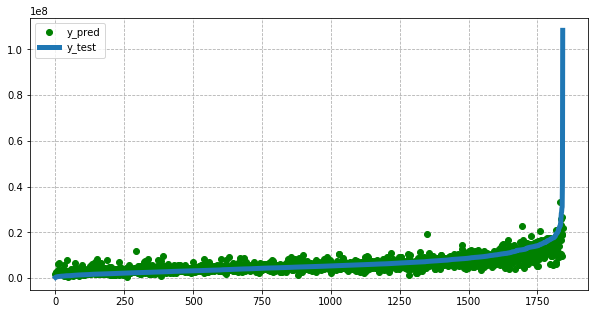

In [17]:
eval_dataset = Pool(X_test[col_50_features], y_test['Basket2'])
    
model = CatBoostRegressor(iterations=900,
                          depth=4,
                          learning_rate=0.03,
                          l2_leaf_reg=4,
                          custom_metric=['R2', 'RMSE', 'MAE', 'MAPE'])
    
model.fit(X_train[col_50_features], y_train['Basket2'], eval_set=eval_dataset, verbose=False)


y_pred = model.predict(X_test)
indices = np.argsort(y_test['Basket2'])#[:1750]

x_plt = np.arange(0, y_test['Basket2'].size)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x_plt, y_pred[indices], 'go', label='y_pred')
ax.plot(x_plt, y_test['Basket2'].iloc[indices], color='tab:blue', linewidth=5, label='y_test')
ax.grid(linestyle='--')
ax.legend()

In [57]:
def plot_train_test_metrics(model):
    x_plt = np.arange(1, model.get_params()['iterations'] + 1)

    plt.figure(figsize=(10, 10))

    plt.subplot(221)
    plt.plot(x_plt, model.evals_result_['learn']['RMSE'], 'r--', label = 'train')
    plt.plot(x_plt, model.evals_result_['validation']['RMSE'], label='test')
    plt.grid(linestyle='--')
    plt.xlabel('iteration', fontsize=12)
    plt.title('RMSE', loc='right', fontsize=12)
    plt.legend()

    plt.subplot(222)
    plt.plot(x_plt, model.evals_result_['learn']['MAE'], 'r--', label = 'train')
    plt.plot(x_plt, model.evals_result_['validation']['MAE'], label='test')
    plt.grid(linestyle='--')
    plt.xlabel('iteration', fontsize=12)
    plt.title('MAE', loc='right', fontsize=12)
    plt.legend()
    
    plt.subplot(223)
    plt.plot(x_plt, model.evals_result_['learn']['R2'], 'r--', label = 'train')
    plt.plot(x_plt, model.evals_result_['validation']['R2'], label='test')
    plt.grid(linestyle='--')
    plt.xlabel('iteration', fontsize=12)
    plt.title('R2', loc='right', fontsize=12)
    plt.legend()
    
    plt.subplot(224)
    plt.plot(x_plt, model.evals_result_['learn']['MAPE'], 'r--', label = 'train')
    plt.plot(x_plt, model.evals_result_['validation']['MAPE'], label='test')
    plt.grid(linestyle='--')
    plt.xlabel('iteration', fontsize=12)
    plt.title('MAPE', loc='right', fontsize=12)
    plt.legend()
    
    plt.show()

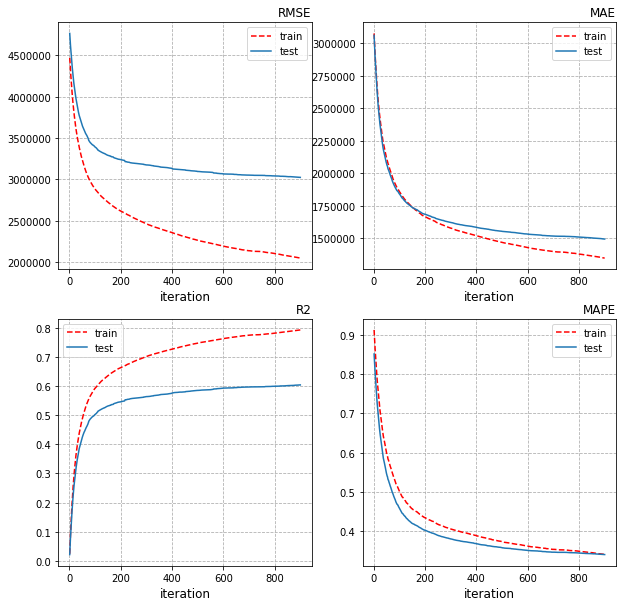

In [58]:
plot_train_test_metrics(model)

### Basket2: *теперь выкинем Новосибирск, Челябинск, Нижн.Новгород, Екатеринбург, Казань*

In [59]:
index_big_cities = []
for i, reg in enumerate(features.OKBrickL3):
    if "новосибирск г" in reg.lower() and "новосибирская" in reg.lower():
        index_big_cities.append(i)
    if "екатеринбург" in reg.lower():
        index_big_cities.append(i)
    if "нижний новгород" in reg.lower():
        index_big_cities.append(i)
    if "казань" in reg.lower():
        index_big_cities.append(i)
    if "челябинск г" in reg.lower() and "челябинская" in reg.lower():
        index_big_cities.append(i)
        
print("Кол-во городов-миллионников: {}".format(len(index_big_cities)))

Кол-во городов-миллионников: 3612


Теперь их надо выкинуть

In [77]:
index_train = list(set(X_train.index) & set(index_big_cities))
index_test = list(set(X_test.index) & set(index_big_cities))

In [78]:
X_train.drop(index_train, axis=0, inplace=True)
y_train.drop(index_train, axis=0, inplace=True)
X_test.drop(index_test, axis=0, inplace=True)
y_test.drop(index_test, axis=0, inplace=True)

**Посмотрим на качество при новых данных**

In [80]:
cv_res(X_train[col_50_features], y_train['Basket2'], y_train['Basket2'].median(),
      iterations=900, depth=4, lr=0.03, l2=4)
test_res(X_train[col_50_features], y_train['Basket2'], X_test[col_50_features], y_test['Basket2'], 
      iterations=900, depth=4, lr=0.03, l2=4)

  cross-validation
RMSE:	2550193.0 +- 186208.0
MAE:	1511725.0 +- 111748.0	(30.0 %)
R2:	0.671 +- 0.03
MAPE:	0.378 +- 0.047
    train - test
RMSE:	train: 2027435.0	test: 2306976.0
R2:	train: 0.793		test: 0.701
MAE:	train: 1325150.0	test: 1449588.0
MAPE:	train: 0.339		test: 0.345


Вообще мне больше нравится. Доверительный интервал меньше, переобучение немного меньше тоже. MAPE только хуже

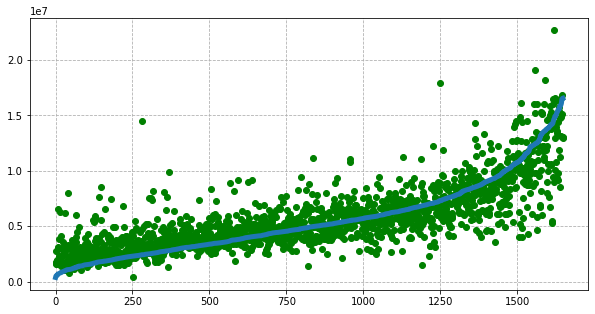

In [81]:
eval_dataset = Pool(X_test[col_50_features], y_test['Basket2'])
    
model = CatBoostRegressor(iterations=900,
                          depth=4,
                          learning_rate=0.03,
                          l2_leaf_reg=4,
                          custom_metric=['R2', 'RMSE', 'MAE', 'MAPE'])
    
model.fit(X_train[col_50_features], y_train['Basket2'], eval_set=eval_dataset, verbose=False)

y_pred = model.predict(X_test[col_50_features])
indices = np.argsort(y_test['Basket2'])[:1650]

x_plt = np.arange(0, y_test['Basket2'][:1650].size)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x_plt, y_pred[indices], 'go')
ax.plot(x_plt, y_test['Basket2'].iloc[indices], color='tab:blue', linewidth=5)
ax.grid(linestyle='--')

Вроде красивее! Но на вкус и цвет товарищей нет.

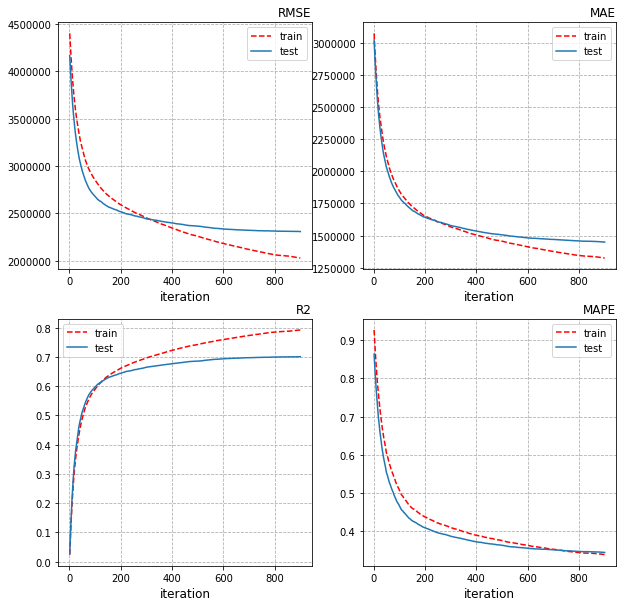

In [82]:
plot_train_test_metrics(model)

> Далее будем брать 700 итераций

## Basket2: *предсказание*

In [83]:
df_ = pd.read_excel('C:\\Users\\dgalk\\shad_final_project\\Universe coded OK July20_ver2.xlsx')

In [84]:
features = pd.concat([features, df_.loc[features.index, 'GlobalCode']], axis=1)

In [85]:
model = CatBoostRegressor(iterations=700,
                          depth=4,
                          learning_rate=0.03,
                          l2_leaf_reg=4,
                          custom_metric=['R2', 'RMSE', 'MAE', 'MAPE'])

model.fit(X_train[col_50_features], y_train['Basket2'], eval_set=eval_dataset, verbose=False)

bask2_pred = model.predict(features[col_50_features])

features['basket2_pred'] = bask2_pred

# Basket1 (аналогичные шаги)

Добавим в список признаков **basket2_pred**

In [86]:
col_full.append('basket2_pred')
X_train['basket2_pred'] = features.loc[X_train.index, 'basket2_pred']
X_test['basket2_pred'] = features.loc[X_test.index, 'basket2_pred']

In [87]:
model = CatBoostRegressor(custom_metric=['R2', 'RMSE', 'MAE', 'MAPE'])

grid = {'learning_rate': [0.03, 0.05, 0.07, 0.1],
        'depth': [4, 5, 6, ],
        'l2_leaf_reg': [1, 2, 3, 4]}

grid_search_result = model.grid_search(grid, 
                                       X=X_train, 
                                       y=y_train['Basket1'],
                                       cv=5,
                                       verbose=False,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 3629470.76
bestIteration = 962


bestTest = 3591636.915
bestIteration = 987


bestTest = 3613969.754
bestIteration = 889


bestTest = 3605917.102
bestIteration = 406


bestTest = 3626135.727
bestIteration = 997


bestTest = 3617160.495
bestIteration = 885


bestTest = 3616645.55
bestIteration = 875


bestTest = 3627933.746
bestIteration = 914


bestTest = 3639386.104
bestIteration = 919


bestTest = 3609767.707
bestIteration = 970


bestTest = 3609737.423
bestIteration = 856


bestTest = 3585610.817
bestIteration = 724


bestTest = 3637330.776
bestIteration = 999


bestTest = 3613581.536
bestIteration = 980


bestTest = 3602898.798
bestIteration = 982


bestTest = 3625767.968
bestIteration = 856


bestTest = 3594460.34
bestIteration = 994


bestTest = 3584495.763
bestIteration = 968


bestTest = 3618327.692
bestIteration = 765


bestTest = 3643044.6
bestIteration = 462


bestTest = 3617086.268
bestIteration = 997


bestTest = 3582018.255
bestIteration = 896


bestTest = 362

Ту же картину наблюдаем с оптимальными гиперпараметрами

In [88]:
num_features = [90, 80, 70, 60, 50, 40, 30, 25]

model = CatBoostRegressor(iterations=1000,
                          depth=4,
                          learning_rate=0.03,
                          l2_leaf_reg=4,
                          verbose=0)

col_ = col_full

for nf in num_features:
    X_ = X_train[col_]
    y_ = y_train['Basket1']
    selector = RFE(model, n_features_to_select=nf, step=1, verbose=0)
    selector = selector.fit(X_, y_)

    col_new = [col_[i] for i, b in enumerate(selector.support_) if b]
    print('***{0} признаков***'.format(nf))
    print(col_new)
    col_ = copy.copy(col_new)

***90 признаков***
['BrandCodes', 'BrickCode', 'Cash', 'Card', 'Internet', 'Bank', 'population', 'VRP', 'NumHos', 'NumAmb', 'NumPhc', 'APT', 'PCP', 'PHK', 'PST', 'top_brand_0', 'top_brand_1', 'top_brand_11', 'top_brand_7', 'top_brand_14', 'top_brand_31', 'top_brand_10', 'top_brand_84', 'top_brand_17', 'top_brand_2', 'top_sales_1', 'top_sales_0', 'top_sales_11', 'top_sales_31', 'top_sales_14', 'top_sales_41', 'top_sales_7', 'top_sales_9', 'top_sales_10', 'top_sales_133', 'top_sales_17', 'top_sales_34', 'top_sales_32', 'top_sales_39', 'Metro_dist', 'Metro_num', 'край', 'обл', 'аллея', 'б-р', 'линия', 'мкр', 'наб', 'нп', 'п', 'парк', 'пл', 'пр-кт', 'проезд', 'рзд', 'спуск', 'тер', 'тракт', 'туп', 'ул', 'уч-к', 'ш', 'Rate123', 'Rate1', 'Rate2', 'Rate3', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'is_work_time_almost_24_7', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_median3', 

In [90]:
col_90_features = \
['BrandCodes', 'BrickCode', 'Cash', 'Card', 'Internet', 'Bank', 'population', 'VRP', 'NumHos', 'NumAmb', 'NumPhc', 'APT', 'PCP', 'PHK', 'PST', 'top_brand_0', 'top_brand_1', 'top_brand_11', 'top_brand_7', 'top_brand_14', 'top_brand_31', 'top_brand_10', 'top_brand_84', 'top_brand_17', 'top_brand_2', 'top_sales_1', 'top_sales_0', 'top_sales_11', 'top_sales_31', 'top_sales_14', 'top_sales_41', 'top_sales_7', 'top_sales_9', 'top_sales_10', 'top_sales_133', 'top_sales_17', 'top_sales_34', 'top_sales_32', 'top_sales_39', 'Metro_dist', 'Metro_num', 'край', 'обл', 'аллея', 'б-р', 'линия', 'мкр', 'наб', 'нп', 'п', 'парк', 'пл', 'пр-кт', 'проезд', 'рзд', 'спуск', 'тер', 'тракт', 'туп', 'ул', 'уч-к', 'ш', 'Rate123', 'Rate1', 'Rate2', 'Rate3', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'is_work_time_almost_24_7', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_median3', 'sell_mean_autumn_median3', 'sell_mean_winter_median3', 'sell_mean_spring_median3', 'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 'num_pharm', 'region_popul', 'soul_on_pharm', 'debcred', 'pens_proc', 'prod_basket', 'pharm_basket', 'basket2_pred']
col_80_features = \
['BrandCodes', 'BrickCode', 'Cash', 'Card', 'Internet', 'Bank', 'population', 'VRP', 'NumHos', 'NumAmb', 'NumPhc', 'APT', 'PCP', 'PST', 'top_brand_0', 'top_brand_1', 'top_brand_11', 'top_brand_7', 'top_brand_14', 'top_brand_31', 'top_brand_10', 'top_brand_17', 'top_brand_2', 'top_sales_1', 'top_sales_0', 'top_sales_11', 'top_sales_31', 'top_sales_14', 'top_sales_7', 'top_sales_9', 'top_sales_10', 'top_sales_17', 'top_sales_34', 'top_sales_32', 'Metro_dist', 'Metro_num', 'край', 'обл', 'аллея', 'б-р', 'линия', 'мкр', 'наб', 'нп', 'пл', 'пр-кт', 'проезд', 'тракт', 'туп', 'ул', 'уч-к', 'ш', 'Rate123', 'Rate1', 'Rate2', 'Rate3', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'is_work_time_almost_24_7', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_median3', 'sell_mean_autumn_median3', 'sell_mean_winter_median3', 'sell_mean_spring_median3', 'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 'num_pharm', 'region_popul', 'soul_on_pharm', 'debcred', 'pens_proc', 'prod_basket', 'pharm_basket', 'basket2_pred']
col_70_features = \
['BrandCodes', 'BrickCode', 'Cash', 'Card', 'Internet', 'Bank', 'population', 'VRP', 'NumHos', 'NumAmb', 'NumPhc', 'PCP', 'PST', 'top_brand_0', 'top_brand_1', 'top_brand_11', 'top_brand_7', 'top_brand_14', 'top_brand_31', 'top_brand_10', 'top_brand_17', 'top_sales_1', 'top_sales_0', 'top_sales_11', 'top_sales_31', 'top_sales_14', 'top_sales_7', 'top_sales_9', 'top_sales_10', 'top_sales_17', 'top_sales_32', 'Metro_dist', 'Metro_num', 'край', 'обл', 'б-р', 'линия', 'мкр', 'наб', 'нп', 'пр-кт', 'тракт', 'ш', 'Rate123', 'Rate1', 'Rate2', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'is_work_time_almost_24_7', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_median3', 'sell_mean_autumn_median3', 'sell_mean_winter_median3', 'sell_mean_spring_median3', 'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 'num_pharm', 'region_popul', 'soul_on_pharm', 'debcred', 'pens_proc', 'prod_basket', 'pharm_basket', 'basket2_pred']
col_60_features = \
['BrandCodes', 'BrickCode', 'Cash', 'Card', 'Bank', 'population', 'VRP', 'NumHos', 'NumAmb', 'NumPhc', 'PCP', 'top_brand_11', 'top_brand_7', 'top_brand_14', 'top_brand_10', 'top_brand_17', 'top_sales_1', 'top_sales_11', 'top_sales_31', 'top_sales_14', 'top_sales_7', 'top_sales_9', 'top_sales_10', 'top_sales_17', 'top_sales_32', 'Metro_dist', 'Metro_num', 'край', 'обл', 'мкр', 'нп', 'пр-кт', 'ш', 'Rate123', 'Rate1', 'Rate2', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'is_work_time_almost_24_7', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_median3', 'sell_mean_autumn_median3', 'sell_mean_winter_median3', 'sell_mean_spring_median3', 'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 'num_pharm', 'region_popul', 'soul_on_pharm', 'debcred', 'pens_proc', 'prod_basket', 'pharm_basket', 'basket2_pred']
col_50_features = \
['BrandCodes', 'BrickCode', 'population', 'VRP', 'NumHos', 'NumAmb', 'NumPhc', 'PCP', 'top_brand_11', 'top_brand_7', 'top_brand_14', 'top_brand_10', 'top_brand_17', 'top_sales_11', 'top_sales_14', 'top_sales_7', 'top_sales_9', 'top_sales_10', 'top_sales_17', 'край', 'обл', 'мкр', 'пр-кт', 'ш', 'Rate123', 'Rate2', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'is_work_time_almost_24_7', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_median3', 'sell_mean_autumn_median3', 'sell_mean_winter_median3', 'sell_mean_spring_median3', 'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 'num_pharm', 'region_popul', 'soul_on_pharm', 'debcred', 'pens_proc', 'prod_basket', 'pharm_basket', 'basket2_pred']
col_40_features = \
['BrandCodes', 'BrickCode', 'population', 'VRP', 'NumHos', 'NumAmb', 'NumPhc', 'top_brand_7', 'top_brand_14', 'top_brand_10', 'top_sales_14', 'top_sales_9', 'top_sales_10', 'top_sales_17', 'край', 'Rate123', 'Rate2', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_median3', 'sell_mean_autumn_median3', 'sell_mean_winter_median3', 'sell_mean_spring_median3', 'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 'num_pharm', 'region_popul', 'soul_on_pharm', 'debcred', 'pens_proc', 'prod_basket', 'pharm_basket', 'basket2_pred']
col_30_features = \
['BrandCodes', 'BrickCode', 'population', 'VRP', 'NumHos', 'NumAmb', 'NumPhc', 'top_sales_14', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_median3', 'sell_mean_autumn_median3', 'sell_mean_winter_median3', 'sell_mean_spring_median3', 'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 'num_pharm', 'region_popul', 'soul_on_pharm', 'pens_proc', 'prod_basket', 'pharm_basket', 'basket2_pred']
col_25_features = \
['BrandCodes', 'BrickCode', 'population', 'VRP', 'NumHos', 'NumAmb', 'top_sales_14', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_median3', 'sell_mean_autumn_median3', 'sell_mean_winter_median3', 'avg_sell_sku_autumn_median3', 'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 'num_pharm', 'soul_on_pharm', 'pens_proc', 'prod_basket', 'basket2_pred']

In [91]:
# 90 признаков
best_iter_ = cv_res(X_train[col_90_features], y_train["Basket1"], y_train["Basket1"].median(),
                    iterations=1000, depth=4, lr=0.03, l2=4)
print("best_iter_: {0}".format(best_iter_))

  cross-validation
RMSE:	3231680.0 +- 568380.0
MAE:	1983831.0 +- 134899.0	(39.0 %)
R2:	0.699 +- 0.08
MAPE:	0.458 +- 0.017
best_iter_: 998


In [92]:
# 80 признаков
best_iter_ = cv_res(X_train[col_80_features], y_train["Basket1"], y_train["Basket1"].median(),
                    iterations=1000, depth=4, lr=0.03, l2=4)
print("best_iter_: {0}".format(best_iter_))

  cross-validation
RMSE:	3219183.0 +- 588980.0
MAE:	1977858.0 +- 142925.0	(39.0 %)
R2:	0.701 +- 0.084
MAPE:	0.456 +- 0.014
best_iter_: 998


In [93]:
# 70 признаков
best_iter_ = cv_res(X_train[col_70_features], y_train["Basket1"], y_train["Basket1"].median(),
                    iterations=1000, depth=4, lr=0.03, l2=4)
print("best_iter_: {0}".format(best_iter_))

  cross-validation
RMSE:	3217231.0 +- 564082.0
MAE:	1977770.0 +- 136251.0	(39.0 %)
R2:	0.701 +- 0.079
MAPE:	0.455 +- 0.021
best_iter_: 999


In [94]:
# 60 признаков
best_iter_ = cv_res(X_train[col_60_features], y_train["Basket1"], y_train["Basket1"].median(),
                    iterations=1000, depth=4, lr=0.03, l2=4)
print("best_iter_: {0}".format(best_iter_))

  cross-validation
RMSE:	3221175.0 +- 599826.0
MAE:	1980491.0 +- 153747.0	(39.0 %)
R2:	0.7 +- 0.086
MAPE:	0.456 +- 0.015
best_iter_: 998


In [95]:
# 50 признаков
best_iter_ = cv_res(X_train[col_50_features], y_train["Basket1"], y_train["Basket1"].median(),
                    iterations=1000, depth=4, lr=0.03, l2=4)
print("best_iter_: {0}".format(best_iter_))

  cross-validation
RMSE:	3225482.0 +- 578523.0
MAE:	1979602.0 +- 150135.0	(39.0 %)
R2:	0.7 +- 0.082
MAPE:	0.456 +- 0.016
best_iter_: 999


In [96]:
# 40 признаков
best_iter_ = cv_res(X_train[col_40_features], y_train["Basket1"], y_train["Basket1"].median(),
                    iterations=1000, depth=4, lr=0.03, l2=4)
print("best_iter_: {0}".format(best_iter_))

  cross-validation
RMSE:	3217016.0 +- 578812.0
MAE:	1977793.0 +- 151673.0	(39.0 %)
R2:	0.701 +- 0.082
MAPE:	0.455 +- 0.018
best_iter_: 999


In [97]:
# 30 признаков
best_iter_ = cv_res(X_train[col_30_features], y_train["Basket1"], y_train["Basket1"].median(),
                    iterations=1000, depth=4, lr=0.03, l2=4)
print("best_iter_: {0}".format(best_iter_))

  cross-validation
RMSE:	3225903.0 +- 577885.0
MAE:	1980711.0 +- 146931.0	(39.0 %)
R2:	0.7 +- 0.082
MAPE:	0.456 +- 0.025
best_iter_: 999


In [98]:
# 25 признаков
best_iter_ = cv_res(X_train[col_25_features], y_train["Basket1"], y_train["Basket1"].median(),
                    iterations=1000, depth=4, lr=0.03, l2=4)
print("best_iter_: {0}".format(best_iter_))

  cross-validation
RMSE:	3215128.0 +- 586381.0
MAE:	1976724.0 +- 143871.0	(39.0 %)
R2:	0.702 +- 0.083
MAPE:	0.455 +- 0.026
best_iter_: 999


Остановимся на 70 признаках

In [99]:
test_res(X_train[col_70_features], y_train['Basket1'], X_test[col_70_features], y_test['Basket1'], 
      iterations=900, depth=4, lr=0.03, l2=4)

    train - test
RMSE:	train: 2682760.0	test: 3470944.0
R2:	train: 0.793		test: 0.609
MAE:	train: 1769644.0	test: 2094060.0
MAPE:	train: 0.428		test: 0.449


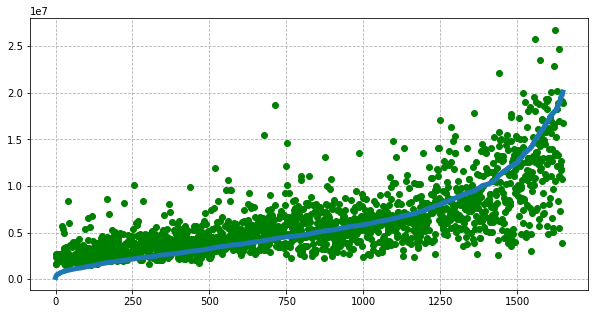

In [100]:
eval_dataset = Pool(X_test[col_70_features], y_test['Basket1'])
    
model = CatBoostRegressor(iterations=900,
                          depth=4,
                          learning_rate=0.03,
                          l2_leaf_reg=4,
                          custom_metric=['R2', 'RMSE', 'MAE', 'MAPE'])
    
model.fit(X_train[col_70_features], y_train['Basket1'], eval_set=eval_dataset, verbose=False)

y_pred = model.predict(X_test[col_70_features])
indices = np.argsort(y_test['Basket1'])[:1650]

x_plt = np.arange(0, y_test['Basket1'][:1650].size)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x_plt, y_pred[indices], 'go')
ax.plot(x_plt, y_test['Basket1'].iloc[indices], color='tab:blue', linewidth=5)
ax.grid(linestyle='--')

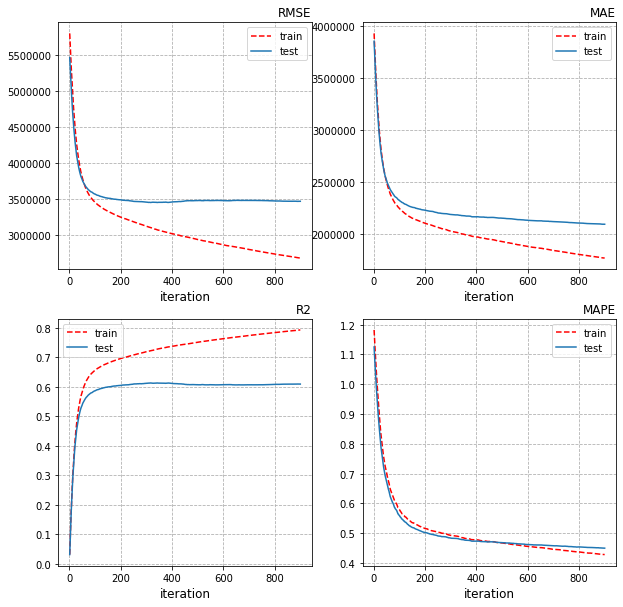

In [101]:
plot_train_test_metrics(model)

> Возьмем 400 итераций (переобучение меньше)

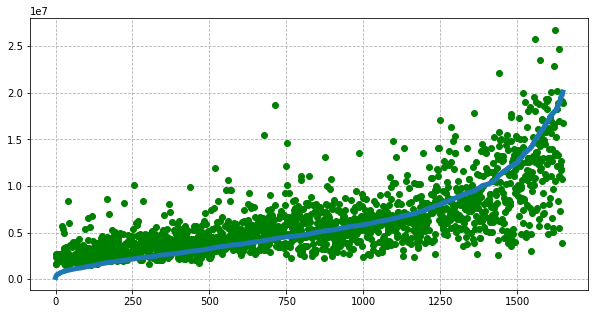

In [102]:
eval_dataset = Pool(X_test[col_70_features], y_test['Basket1'])
    
model = CatBoostRegressor(iterations=400,
                          depth=4,
                          learning_rate=0.03,
                          l2_leaf_reg=4,
                          custom_metric=['R2', 'RMSE', 'MAE', 'MAPE'])
    
model.fit(X_train[col_70_features], y_train['Basket1'], eval_set=eval_dataset, verbose=False)

y_pred = model.predict(X_test[col_70_features])
indices = np.argsort(y_test['Basket1'])[:1650]

x_plt = np.arange(0, y_test['Basket1'][:1650].size)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x_plt, y_pred[indices], 'go')
ax.plot(x_plt, y_test['Basket1'].iloc[indices], color='tab:blue', linewidth=5)
ax.grid(linestyle='--')

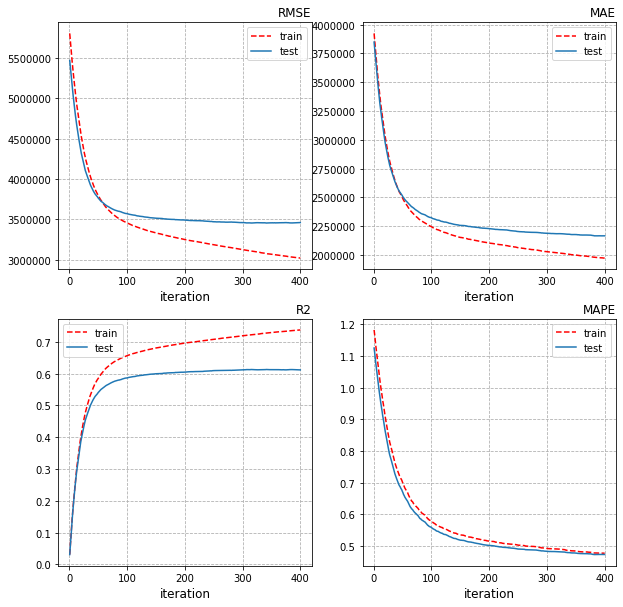

In [103]:
plot_train_test_metrics(model)

## Basket1: *предсказание*

In [104]:
bask1_pred = model.predict(features[col_70_features])
features['basket1_pred'] = bask1_pred

# Basket3 (аналогичные шаги)

Добавим новые признаки

In [105]:
features["basket_prod"] = bask1_pred * bask2_pred
features["bask1 / bask2"] = bask1_pred / bask2_pred

col_full.append('basket1_pred')
col_full.append('basket_prod')
col_full.append('bask1 / bask2')

X_train['basket1_pred'] = features.loc[X_train.index, 'basket1_pred']
X_test['basket1_pred'] = features.loc[X_test.index, 'basket1_pred']

X_train['basket_prod'] = features.loc[X_train.index, 'basket_prod']
X_test['basket_prod'] = features.loc[X_test.index, 'basket_prod']

X_train['bask1 / bask2'] = features.loc[X_train.index, 'bask1 / bask2']
X_test['bask1 / bask2'] = features.loc[X_test.index, 'bask1 / bask2']

## Basket3: первый baseline

In [106]:
best_iter_ = cv_res(X_train[col_full], y_train['Basket3'], y_train['Basket3'].median(),
                    iterations=1000, depth=4, lr=0.03, l2=4)
print("best_iter_: {0}".format(best_iter_))

  cross-validation
RMSE:	414632.0 +- 31286.0
MAE:	245716.0 +- 12525.0	(47.0 %)
R2:	0.7 +- 0.07
MAPE:	0.571 +- 0.066
best_iter_: 999


In [107]:
test_res(X_train[col_full], y_train['Basket3'], X_test[col_full], y_test['Basket3'], 
         iterations=1000, depth=4, lr=0.03, l2=4)

    train - test
RMSE:	train: 331881.0	test: 391164.0
R2:	train: 0.809		test: 0.654
MAE:	train: 213770.0	test: 236020.0
MAPE:	train: 0.526		test: 0.567


In [108]:
model = CatBoostRegressor(custom_metric=['R2', 'RMSE', 'MAE', 'MAPE'])

grid = {'learning_rate': [0.02, 0.03, 0.05, 0.07],
        'depth': [3, 4, 5, ],
        'l2_leaf_reg': [1, 2, 3, 4]}

grid_search_result = model.grid_search(grid, 
                                       X=X_train[col_full], 
                                       y=y_train['Basket3'],
                                       cv=5,
                                       verbose=False,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 411747.1796
bestIteration = 999


bestTest = 406415.612
bestIteration = 997


bestTest = 400622.9311
bestIteration = 999


bestTest = 397587.7192
bestIteration = 969


bestTest = 412252.6864
bestIteration = 999


bestTest = 406814.0237
bestIteration = 998


bestTest = 403542.7537
bestIteration = 999


bestTest = 401112.62
bestIteration = 982


bestTest = 412431.8988
bestIteration = 998


bestTest = 408113.4537
bestIteration = 999


bestTest = 403217.3262
bestIteration = 999


bestTest = 398153.6545
bestIteration = 999


bestTest = 412911.5674
bestIteration = 998


bestTest = 407137.7098
bestIteration = 999


bestTest = 401287.5499
bestIteration = 997


bestTest = 399391.7641
bestIteration = 993


bestTest = 406902.9128
bestIteration = 999


bestTest = 401258.2462
bestIteration = 998


bestTest = 395953.1873
bestIteration = 985


bestTest = 396624.5469
bestIteration = 947


bestTest = 407128.7419
bestIteration = 999


bestTest = 403898.3924
bestIteration = 998


bestTest = 3

   Возьмем параметры, при которых на трейне худший результат, тогда переобучение меньше
    
<li>depth = 3
    
<li>learning_rate = 0.02
    
<li>l2_leaf_reg = 4

In [109]:
best_iter_ = cv_res(X_train[col_full], y_train['Basket3'], y_train['Basket3'].median(),
                    iterations=1000, depth=3, lr=0.02, l2=4)
print("best_iter_: {0}".format(best_iter_))

  cross-validation
RMSE:	423052.0 +- 33485.0
MAE:	256187.0 +- 12074.0	(49.0 %)
R2:	0.688 +- 0.072
MAPE:	0.611 +- 0.08
best_iter_: 998


In [110]:
test_res(X_train[col_full], y_train['Basket3'], X_test[col_full], y_test['Basket3'], 
      iterations=1000, depth=3, lr=0.02, l2=4)

    train - test
RMSE:	train: 375702.0	test: 405719.0
R2:	train: 0.755		test: 0.627
MAE:	train: 237849.0	test: 248093.0
MAPE:	train: 0.584		test: 0.604


In [111]:
num_features = [90, 80, 70, 60, 50, 40, 30, 25]

model = CatBoostRegressor(iterations=1000,
                          depth=3,
                          learning_rate=0.02,
                          l2_leaf_reg=4,
                          verbose=0)

col_ = col_full

for nf in num_features:
    X_ = X_train[col_]
    y_ = y_train['Basket3']
    selector = RFE(model, n_features_to_select=nf, step=1, verbose=0)
    selector = selector.fit(X_, y_)

    col_new = [col_[i] for i, b in enumerate(selector.support_) if b]
    print('***{0} признаков***'.format(nf))
    print(col_new)
    col_ = copy.copy(col_new)

***90 признаков***
['BrandCodes', 'BrickCode', 'Cash', 'Card', 'Internet', 'Bank', 'population', 'VRP', 'NumHos', 'NumAmb', 'NumPhc', 'APT', 'PCP', 'PHN', 'top_brand_0', 'top_brand_1', 'top_brand_11', 'top_brand_7', 'top_brand_14', 'top_brand_31', 'top_brand_10', 'top_brand_84', 'top_brand_17', 'top_brand_2', 'top_sales_1', 'top_sales_0', 'top_sales_11', 'top_sales_31', 'top_sales_14', 'top_sales_84', 'top_sales_41', 'top_sales_7', 'top_sales_133', 'top_sales_34', 'top_sales_32', 'top_sales_39', 'Metro_dist', 'АО', 'Респ', 'край', 'обл', 'аллея', 'б-р', 'наб', 'нп', 'парк', 'пер', 'пр-кт', 'проезд', 'рзд', 'ряды', 'сл', 'спуск', 'тер', 'тракт', 'туп', 'ул', 'уч-к', 'ш', 'Rate123', 'Rate1', 'Rate2', 'Rate3', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'is_work_time_almost_24_7', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_median3', 'sell_mean_autumn_median3', 'sell_mean_wint

In [112]:
col_90_features = \
['BrandCodes', 'BrickCode', 'Cash', 'Card', 'Internet', 'Bank', 'population', 'VRP', 'NumHos', 'NumAmb', 'NumPhc', 'APT', 'PCP', 'PHN', 'top_brand_0', 'top_brand_1', 'top_brand_11', 'top_brand_7', 'top_brand_14', 'top_brand_31', 'top_brand_10', 'top_brand_84', 'top_brand_17', 'top_brand_2', 'top_sales_1', 'top_sales_0', 'top_sales_11', 'top_sales_31', 'top_sales_14', 'top_sales_84', 'top_sales_41', 'top_sales_7', 'top_sales_133', 'top_sales_34', 'top_sales_32', 'top_sales_39', 'Metro_dist', 'АО', 'Респ', 'край', 'обл', 'аллея', 'б-р', 'наб', 'нп', 'парк', 'пер', 'пр-кт', 'проезд', 'рзд', 'ряды', 'сл', 'спуск', 'тер', 'тракт', 'туп', 'ул', 'уч-к', 'ш', 'Rate123', 'Rate1', 'Rate2', 'Rate3', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'is_work_time_almost_24_7', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_median3', 'sell_mean_autumn_median3', 'sell_mean_winter_median3', 'sell_mean_spring_median3', 'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 'num_pharm', 'region_popul', 'soul_on_pharm', 'debcred', 'pens_proc', 'prod_basket', 'pharm_basket', 'basket2_pred', 'basket1_pred', 'basket_prod', 'bask1 / bask2']
col_80_features = \
['BrandCodes', 'BrickCode', 'Cash', 'Card', 'Internet', 'Bank', 'population', 'VRP', 'NumHos', 'NumAmb', 'NumPhc', 'APT', 'PCP', 'PHN', 'top_brand_0', 'top_brand_1', 'top_brand_11', 'top_brand_7', 'top_brand_14', 'top_brand_31', 'top_brand_10', 'top_brand_84', 'top_brand_2', 'top_sales_0', 'top_sales_11', 'top_sales_31', 'top_sales_14', 'top_sales_84', 'top_sales_7', 'top_sales_133', 'top_sales_34', 'top_sales_32', 'top_sales_39', 'Metro_dist', 'Респ', 'край', 'обл', 'аллея', 'б-р', 'наб', 'нп', 'пр-кт', 'ряды', 'сл', 'спуск', 'тракт', 'туп', 'ул', 'уч-к', 'ш', 'Rate123', 'Rate1', 'Rate2', 'Rate3', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_median3', 'sell_mean_autumn_median3', 'sell_mean_winter_median3', 'sell_mean_spring_median3', 'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 'num_pharm', 'region_popul', 'soul_on_pharm', 'debcred', 'pens_proc', 'prod_basket', 'pharm_basket', 'basket2_pred', 'basket1_pred', 'basket_prod', 'bask1 / bask2']
col_70_features = \
['BrandCodes', 'BrickCode', 'Cash', 'Card', 'Internet', 'Bank', 'population', 'VRP', 'NumHos', 'NumAmb', 'NumPhc', 'APT', 'PCP', 'top_brand_0', 'top_brand_11', 'top_brand_7', 'top_brand_14', 'top_brand_31', 'top_brand_84', 'top_sales_11', 'top_sales_31', 'top_sales_14', 'top_sales_84', 'top_sales_7', 'top_sales_133', 'top_sales_34', 'top_sales_32', 'Metro_dist', 'край', 'обл', 'аллея', 'б-р', 'наб', 'нп', 'пр-кт', 'сл', 'тракт', 'туп', 'ул', 'уч-к', 'ш', 'Rate1', 'Rate2', 'Rate3', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_median3', 'sell_mean_autumn_median3', 'sell_mean_winter_median3', 'sell_mean_spring_median3', 'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 'num_pharm', 'region_popul', 'soul_on_pharm', 'debcred', 'pens_proc', 'prod_basket', 'pharm_basket', 'basket2_pred', 'basket1_pred', 'basket_prod', 'bask1 / bask2']
col_60_features = \
['BrandCodes', 'BrickCode', 'Internet', 'Bank', 'population', 'VRP', 'NumHos', 'NumAmb', 'NumPhc', 'APT', 'PCP', 'top_brand_11', 'top_brand_7', 'top_brand_14', 'top_brand_31', 'top_brand_84', 'top_sales_11', 'top_sales_31', 'top_sales_14', 'top_sales_84', 'top_sales_7', 'top_sales_133', 'top_sales_34', 'top_sales_32', 'Metro_dist', 'обл', 'б-р', 'наб', 'нп', 'тракт', 'ул', 'Rate1', 'Rate2', 'Rate3', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_median3', 'sell_mean_autumn_median3', 'sell_mean_winter_median3', 'sell_mean_spring_median3', 'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 'num_pharm', 'region_popul', 'soul_on_pharm', 'debcred', 'pens_proc', 'prod_basket', 'pharm_basket', 'basket2_pred', 'basket1_pred', 'basket_prod', 'bask1 / bask2']
col_50_features = \
['BrandCodes', 'BrickCode', 'population', 'VRP', 'NumHos', 'NumAmb', 'NumPhc', 'PCP', 'top_brand_11', 'top_brand_7', 'top_brand_14', 'top_brand_31', 'top_brand_84', 'top_sales_11', 'top_sales_31', 'top_sales_14', 'top_sales_84', 'top_sales_7', 'top_sales_34', 'top_sales_32', 'тракт', 'ул', 'Rate1', 'Rate2', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_median3', 'sell_mean_autumn_median3', 'sell_mean_winter_median3', 'sell_mean_spring_median3', 'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 'num_pharm', 'region_popul', 'soul_on_pharm', 'debcred', 'pens_proc', 'prod_basket', 'pharm_basket', 'basket2_pred', 'basket1_pred', 'basket_prod', 'bask1 / bask2']
col_40_features = \
['BrandCodes', 'population', 'VRP', 'NumAmb', 'NumPhc', 'top_brand_11', 'top_brand_7', 'top_brand_31', 'top_brand_84', 'top_sales_11', 'top_sales_31', 'top_sales_84', 'top_sales_7', 'Rate2', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_median3', 'sell_mean_autumn_median3', 'sell_mean_winter_median3', 'sell_mean_spring_median3', 'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 'num_pharm', 'region_popul', 'soul_on_pharm', 'debcred', 'pens_proc', 'prod_basket', 'pharm_basket', 'basket2_pred', 'basket1_pred', 'basket_prod', 'bask1 / bask2']
col_30_features = \
['BrandCodes', 'population', 'VRP', 'NumAmb', 'top_brand_11', 'top_brand_84', 'top_sales_84', 'Rate_mean', 'weekdays_work_time', 'weekend_work_time', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'sell_mean_summer_median3', 'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 'num_pharm', 'region_popul', 'soul_on_pharm', 'debcred', 'pens_proc', 'prod_basket', 'pharm_basket', 'basket2_pred', 'basket1_pred', 'basket_prod', 'bask1 / bask2']
col_25_features = \
['BrandCodes', 'population', 'VRP', 'NumAmb', 'top_brand_11', 'top_brand_84', 'top_sales_84', 'Rate_mean', 'weekend_work_time', 'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3', 'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 'avg_sell_sku_summer_median3', 'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3', 'region_popul', 'debcred', 'pens_proc', 'prod_basket', 'pharm_basket', 'basket2_pred', 'basket1_pred', 'basket_prod', 'bask1 / bask2']

In [113]:
# 90 признаков
best_iter_ = cv_res(X_train[col_90_features], y_train['Basket3'], y_train['Basket3'].median(),
                    iterations=1000, depth=3, lr=0.02, l2=4)
print("best_iter_: {0}".format(best_iter_))

  cross-validation
RMSE:	423501.0 +- 35241.0
MAE:	256317.0 +- 12565.0	(49.0 %)
R2:	0.687 +- 0.077
MAPE:	0.612 +- 0.083
best_iter_: 997


In [114]:
# 80 признаков
best_iter_ = cv_res(X_train[col_80_features], y_train['Basket3'], y_train['Basket3'].median(),
                    iterations=1000, depth=3, lr=0.02, l2=4)
print("best_iter_: {0}".format(best_iter_))

  cross-validation
RMSE:	422637.0 +- 35362.0
MAE:	256468.0 +- 12314.0	(49.0 %)
R2:	0.688 +- 0.077
MAPE:	0.611 +- 0.082
best_iter_: 996


In [115]:
# 70 признаков
best_iter_ = cv_res(X_train[col_70_features], y_train['Basket3'], y_train['Basket3'].median(),
                    iterations=1000, depth=3, lr=0.02, l2=4)
print("best_iter_: {0}".format(best_iter_))

  cross-validation
RMSE:	423137.0 +- 34273.0
MAE:	256033.0 +- 12517.0	(49.0 %)
R2:	0.688 +- 0.074
MAPE:	0.611 +- 0.08
best_iter_: 999


In [116]:
# 60 признаков
best_iter_ = cv_res(X_train[col_60_features], y_train['Basket3'], y_train['Basket3'].median(),
                    iterations=1000, depth=3, lr=0.02, l2=4)
print("best_iter_: {0}".format(best_iter_))

  cross-validation
RMSE:	422186.0 +- 34591.0
MAE:	255823.0 +- 12340.0	(49.0 %)
R2:	0.689 +- 0.076
MAPE:	0.611 +- 0.08
best_iter_: 999


In [117]:
# 50 признаков
best_iter_ = cv_res(X_train[col_50_features], y_train['Basket3'], y_train['Basket3'].median(),
                    iterations=1000, depth=3, lr=0.02, l2=4)
print("best_iter_: {0}".format(best_iter_))

  cross-validation
RMSE:	422352.0 +- 34727.0
MAE:	255734.0 +- 13283.0	(49.0 %)
R2:	0.689 +- 0.076
MAPE:	0.611 +- 0.08
best_iter_: 998


In [118]:
# 40 признаков
best_iter_ = cv_res(X_train[col_40_features], y_train['Basket3'], y_train['Basket3'].median(),
                    iterations=1000, depth=3, lr=0.02, l2=4)
print("best_iter_: {0}".format(best_iter_))

  cross-validation
RMSE:	422506.0 +- 35638.0
MAE:	255436.0 +- 12451.0	(49.0 %)
R2:	0.689 +- 0.076
MAPE:	0.608 +- 0.076
best_iter_: 999


In [119]:
# 30 признаков
best_iter_ = cv_res(X_train[col_30_features], y_train['Basket3'], y_train['Basket3'].median(),
                    iterations=1000, depth=3, lr=0.02, l2=4)
print("best_iter_: {0}".format(best_iter_))

  cross-validation
RMSE:	423164.0 +- 35416.0
MAE:	255711.0 +- 12918.0	(49.0 %)
R2:	0.688 +- 0.076
MAPE:	0.605 +- 0.08
best_iter_: 999


In [120]:
# 25 признаков
best_iter_ = cv_res(X_train[col_25_features], y_train['Basket3'], y_train['Basket3'].median(),
                    iterations=1000, depth=3, lr=0.02, l2=4)
print("best_iter_: {0}".format(best_iter_))

  cross-validation
RMSE:	424381.0 +- 34796.0
MAE:	255915.0 +- 12441.0	(49.0 %)
R2:	0.686 +- 0.076
MAPE:	0.605 +- 0.087
best_iter_: 999


Возьмем 60 признаков

In [121]:
test_res(X_train[col_60_features], y_train['Basket3'], X_test[col_60_features], y_test['Basket3'], 
      iterations=900, depth=3, lr=0.02, l2=4)

    train - test
RMSE:	train: 380039.0	test: 408121.0
R2:	train: 0.75		test: 0.623
MAE:	train: 240354.0	test: 249847.0
MAPE:	train: 0.593		test: 0.609


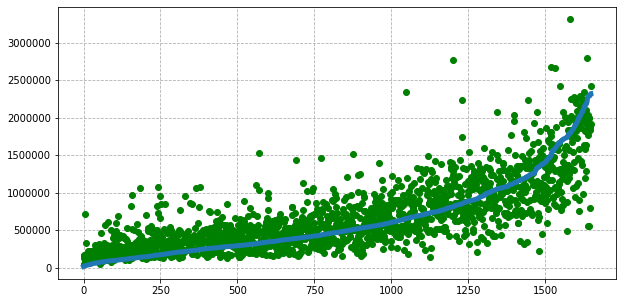

In [122]:
eval_dataset = Pool(X_test[col_60_features], y_test['Basket3'])
    
model = CatBoostRegressor(iterations=900,
                          depth=3,
                          learning_rate=0.02,
                          l2_leaf_reg=4,
                          custom_metric=['R2', 'RMSE', 'MAE', 'MAPE'])
    
model.fit(X_train[col_60_features], y_train['Basket3'], eval_set=eval_dataset, verbose=False)

y_pred = model.predict(X_test[col_60_features])
indices = np.argsort(y_test['Basket3'])[:1650]

x_plt = np.arange(0, y_test['Basket3'][:1650].size)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x_plt, y_pred[indices], 'go')
ax.plot(x_plt, y_test['Basket3'].iloc[indices], color='tab:blue', linewidth=5)
ax.grid(linestyle='--')

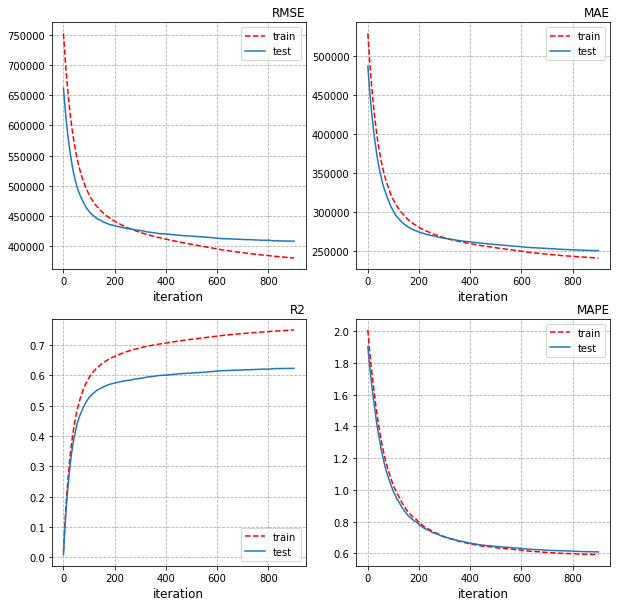

In [123]:
plot_train_test_metrics(model)

## Basket3: *предсказание*

In [124]:
bask3_pred = model.predict(features[col_60_features])
features['basket3_pred'] = bask3_pred

# Создание финльной таблицы и занесение в Excel-файл

In [125]:
basket_prediction_rest_russia = pd.DataFrame()
basket_prediction_rest_russia['OneKeyID'] = features['OneKeyID']
basket_prediction_rest_russia['GlobalCode'] = features['GlobalCode']
basket_prediction_rest_russia['BrickCode'] = features['BrickCode']
basket_prediction_rest_russia['Basket1'] = features['Basket1']
basket_prediction_rest_russia['Basket2'] = features['Basket2']
basket_prediction_rest_russia['Basket3'] = features['Basket3']
basket_prediction_rest_russia['Basket1_pred'] = features['basket1_pred']
basket_prediction_rest_russia['Basket2_pred'] = features['basket2_pred']
basket_prediction_rest_russia['Basket3_pred'] = features['basket3_pred']

In [126]:
index_empty_basket = basket_prediction_rest_russia[pd.isnull(basket_prediction_rest_russia.Basket1)].index

In [127]:
col_bask = ['Basket1', 'Basket2', 'Basket3']
col_bask_pred = ['Basket1_pred', 'Basket2_pred', 'Basket3_pred']
basket_prediction_rest_russia.loc[index_empty_basket, 'Basket1'] = \
    basket_prediction_rest_russia.loc[index_empty_basket, 'Basket1_pred']
basket_prediction_rest_russia.loc[index_empty_basket, 'Basket2'] = \
    basket_prediction_rest_russia.loc[index_empty_basket, 'Basket2_pred']
basket_prediction_rest_russia.loc[index_empty_basket, 'Basket3'] = \
    basket_prediction_rest_russia.loc[index_empty_basket, 'Basket3_pred']

In [128]:
basket_prediction_rest_russia.drop(['Basket1_pred', 'Basket2_pred', 'Basket3_pred'], axis=1, inplace=True)

In [129]:
basket_prediction_rest_russia.head()

,OneKeyID,GlobalCode,BrickCode,Basket1,Basket2,Basket3
0,WRUE00003190,NaN,800280,4.462255e+06,3.967848e+06,232784.520878
1,WRUF00000566,2052648.0,800280,2.240351e+06,1.980709e+06,254888.223000
2,WRUF00000721,NaN,800280,5.242599e+06,4.401689e+06,598581.809161
3,WRUF00000722,NaN,800280,6.053834e+06,3.260500e+06,614005.455700
4,WRUF00001113,NaN,800280,5.604575e+06,5.022187e+06,397703.254274


In [130]:
index_big_cities = []
for i, reg in enumerate(features.OKBrickL3):
    if "новосибирск г" in reg.lower() and "новосибирская" in reg.lower():
        index_big_cities.append(i)
    if "екатеринбург" in reg.lower():
        index_big_cities.append(i)
    if "нижний новгород" in reg.lower():
        index_big_cities.append(i)
    if "казань" in reg.lower():
        index_big_cities.append(i)
    if "челябинск г" in reg.lower() and "челябинская" in reg.lower():
        index_big_cities.append(i)
        
print("Кол-во городов-миллионников: {}".format(len(index_big_cities)))

Кол-во городов-миллионников: 3612


In [131]:
basket_prediction_rest_russia.drop(index_big_cities, axis=0, inplace=True)

In [132]:
basket_prediction_rest_russia.shape

(50914, 6)

In [133]:
basket_prediction_rest_russia.to_excel("C:\\Users\\dgalk\\shad_final_project\\basket_prediction_rest_russia.xlsx", 
                                       index=False)

In [138]:
y__ = np.concatenate((y_train, y_test))

In [139]:
y__.shape

(8483, 3)

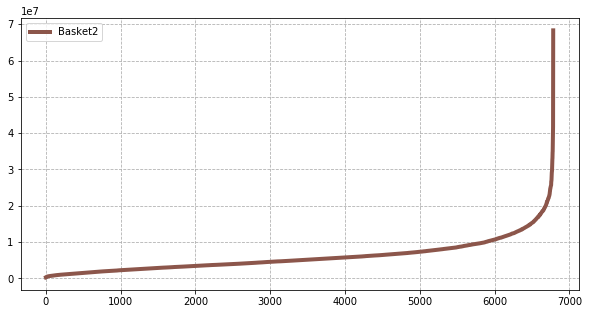

In [148]:
plot_one_graphic_sorted(y_train['Basket2'], label='Basket2')

In [141]:
y__

array([[ 3801971.3191   ,  3556823.5749   ,   262361.1384   ],
       [ 8931247.9024073,  6570571.84     ,  1326171.95     ],
       [15175438.9029   , 11482732.0731   ,  1747985.5497   ],
       ...,
       [ 6027336.0116114,  5552981.0579089,  2005710.7731817],
       [17218809.2100735, 15299898.99     ,  1023658.05     ],
       [24721041.8751243, 14660377.9001   ,  1244078.51     ]])